# 9 Read Random Forest
before and after treatments on Cle Elum Ridge   

### Notebook contents 
* Opening the netcdfs created in the *rapid_model_create_netcdf.ipynb* notebook 
* Running the Chapter 2 Bin 1 Random Forest Model on CER before and after treatments 

created by Cassie Lumbrazo\
date: October 2023\
python environment: **raster**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

In [2]:
import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
# The two netcdfs created in the previous notebook, one has some correction for negative snow depth values and the other has the snow depth values cut at zero
# ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_cutatzero.nc') # for the snow depth values cut a zero
# ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros

ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero_randomforest.nc') # for the snow depth values negative to zeros

In [4]:
ds

<xarray.Dataset>
Dimensions:                    (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                          (x) float64 4.65e+05 4.65e+05 ... 4.676e+05
  * y                          (y) float64 2.111e+05 2.111e+05 ... 2.097e+05
  * band                       (band) int32 1
    spatial_ref                int32 ...
Data variables: (12/52)
    hs_ncalm_model             (y, x, band) float64 ...
    hs_rapid_model             (y, x, band) float64 ...
    diff_hs_rapid_ncalm_model  (y, x, band) float64 ...
    diff_hs_model_rapid        (y, x, band) float64 ...
    diff_hs_model_ncalm        (y, x, band) float64 ...
    diff_delta_hs_model_obs    (y, x, band) float64 ...
    ...                         ...
    diff_chm_ncalm_snowoff     (band, y, x) float32 ...
    diff_chm_rapid_ncalm       (band, y, x) float32 ...
    diff_chm_snowoff_rapid     (band, y, x) float32 ...
    diff_chm_snowoff_ncalm     (band, y, x) float32 ...
    diff_chm_ncalm_rapid       (band, y, x) float32 ...
    diff_dce_rapid_ncalm       (band, y, x) float32 ...

Calculations for change in forest structure depending on aspect

In [5]:
ds['diff_chm_rapid_snowoff'] = ds['chmws_rapid'] - ds['chm_snowoff']
ds['diff_chm_ncalm_snowoff'] = ds['chmws_ncalm'] - ds['chm_snowoff']
ds['diff_chm_rapid_ncalm'] =   ds['chmws_rapid'] - ds['chmws_ncalm']

ds['diff_chm_snowoff_rapid'] =  ds['chm_snowoff']- ds['chmws_rapid']
ds['diff_chm_snowoff_ncalm'] =  ds['chm_snowoff']- ds['chmws_ncalm']
ds['diff_chm_ncalm_rapid'] =    ds['chmws_ncalm']- ds['chmws_rapid'] 

In [6]:
# this code calculates the the change in lidar at 5 meters 
ds['lidar_canopychange'] = ds['diff_chm_rapid_snowoff'].where(ds['diff_chm_rapid_snowoff'] < -5) # removed trees, can change this... but for now, 5
ds['lidar_nocanopychange'] = ds['diff_chm_rapid_snowoff'].where(ds['diff_chm_rapid_snowoff'] >= 0) # stayed the same 

# also, remove outliers from the change canopy 
ds['lidar_nocanopychange'] = ds['lidar_nocanopychange'].where(ds['lidar_nocanopychange'] < 40) # I saw some outliers when plotting so remove those points

# use the change canopy and no change canopy to make a binary variable
ds['lidar_canopychange_binary'] = ds['lidar_canopychange'].copy(deep=True) # first copy the variable
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].fillna(0) # then fill the nans with 0
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds['lidar_canopychange_binary'] == 0, 1) # where condition is FALSE, fill with 1
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds['diff_chm_rapid_snowoff'])
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

In [7]:
# create binary variable for baf
ds['baf_canopychange_binary'] = np.nan 
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].fillna(0) # then fill the nans with 0
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].where(~(ds['baf'] > 0), 1) # any BAF means canopy change
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

# also, create this variable to call later with the lidar change
ds['baf_canopychange'] = ds['baf_canopychange_binary'].where(ds['baf_canopychange_binary'] == 1, np.nan)
ds['baf_nocanopychange']= ds['baf_canopychange_binary'].where(ds['baf_canopychange_binary'] == 0, np.nan)

In [8]:
# create binary object for dah
ds['dah_binary'] = np.nan
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] >= 0), 1)  # where DAH is greater than 0, then 1 for high heat index
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] < 0), -1) # where DAH is less than or equal to 0, then -1 for low heat index
ds['dah_binary'] = ds['dah_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

In [9]:
# the numbers above show the calculate bounds for this option
ds['aspect_north'] = ds['aspect'].where((ds['aspect'] >= 325) | (ds['aspect'] <= 55)) # greater than 300 or less than 120 north
ds['aspect_south'] = ds['aspect'].where((ds['aspect'] >= 155) & (ds['aspect'] <= 245)) # between 120 and 300 south

# also, create an aspect binary variable to use later 
ds['aspect_binary'] = np.nan
ds['aspect_binary'] = ds['aspect_binary'].where(~((ds['aspect'] >= 325) | (ds['aspect'] <= 55)), 0) # where not false (true) fill 0
ds['aspect_binary'] = ds['aspect_binary'].where(~((ds['aspect'] >= 155) & (ds['aspect'] <= 245)), 1) 

# therefore, south is 0 and north is 1 
ds['aspect_binary'] = ds['aspect_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

Find where the forest changed or did not, on each aspect 

In [10]:
# lidar canopy change
# aspect 
ds['lidar_canopychange_north'] = ds['lidar_canopychange'].where(ds['aspect_north'] >= 0) # north
ds['lidar_canopychange_south'] = ds['lidar_canopychange'].where(ds['aspect_south'] >= 0) # south

ds['lidar_nocanopychange_north'] = ds['lidar_nocanopychange'].where(ds['aspect_north'] >= 0) # north
ds['lidar_nocanopychange_south'] = ds['lidar_nocanopychange'].where(ds['aspect_south'] >= 0) # south

# dah 
ds['lidar_canopychange_dahneg'] = ds['lidar_canopychange'].where(ds['dah_binary'] == -1) # low dah
ds['lidar_canopychange_dahpos'] = ds['lidar_canopychange'].where(ds['dah_binary'] == 1) # high dah

ds['lidar_nocanopychange_dahneg'] = ds['lidar_nocanopychange'].where(ds['dah_binary'] == -1) # low dah
ds['lidar_nocanopychange_dahpos'] = ds['lidar_nocanopychange'].where(ds['dah_binary'] == 1) # high dah

# same, with baf canopy change
# aspect 
ds['baf_canopychange_north'] = ds['baf_canopychange'].where(ds['aspect_north'] >= 0) # north
ds['baf_canopychange_south'] = ds['baf_canopychange'].where(ds['aspect_south'] >= 0) # south

ds['baf_nocanopychange_north'] = ds['baf_nocanopychange'].where(ds['aspect_north'] >= 0) # north
ds['baf_nocanopychange_south'] = ds['baf_nocanopychange'].where(ds['aspect_south'] >= 0) # south

# dah 
ds['baf_canopychange_dahneg'] = ds['baf_canopychange'].where(ds['dah_binary'] == -1) # low dah
ds['baf_canopychange_dahpos'] = ds['baf_canopychange'].where(ds['dah_binary'] == 1) # high dah

ds['baf_nocanopychange_dahneg'] = ds['baf_nocanopychange'].where(ds['dah_binary'] == -1) # low dah
ds['baf_nocanopychange_dahpos'] = ds['baf_nocanopychange'].where(ds['dah_binary'] == 1) # high dah

In [11]:
# now, save snow depth as a variable for each of those conditions, where the values are not null
ds['hs_lidar_canopychange_north'] = ds['hs_rapid'].where(ds['lidar_canopychange_north'].notnull())
ds['hs_lidar_canopychange_south'] = ds['hs_rapid'].where(ds['lidar_canopychange_south'].notnull())
ds['hs_lidar_nocanopychange_north'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_north'].notnull())
ds['hs_lidar_nocanopychange_south'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_south'].notnull())

ds['hs_lidar_canopychange_dahneg'] = ds['hs_rapid'].where(ds['lidar_canopychange_dahneg'].notnull())
ds['hs_lidar_canopychange_dahpos'] = ds['hs_rapid'].where(ds['lidar_canopychange_dahpos'].notnull())
ds['hs_lidar_nocanopychange_dahneg'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_dahneg'].notnull())
ds['hs_lidar_nocanopychange_dahpos'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_dahpos'].notnull())

# same, with baf canopy change
ds['hs_baf_canopychange_north'] = ds['hs_rapid'].where(ds['baf_canopychange_north'].notnull())
ds['hs_baf_canopychange_south'] = ds['hs_rapid'].where(ds['baf_canopychange_south'].notnull())
ds['hs_baf_nocanopychange_north'] = ds['hs_rapid'].where(ds['baf_nocanopychange_north'].notnull())
ds['hs_baf_nocanopychange_south'] = ds['hs_rapid'].where(ds['baf_nocanopychange_south'].notnull())


ds['hs_baf_canopychange_dahneg'] = ds['hs_rapid'].where(ds['baf_canopychange_dahneg'].notnull())
ds['hs_baf_canopychange_dahpos'] = ds['hs_rapid'].where(ds['baf_canopychange_dahpos'].notnull())
ds['hs_baf_nocanopychange_dahneg'] = ds['hs_rapid'].where(ds['baf_nocanopychange_dahneg'].notnull())
ds['hs_baf_nocanopychange_dahpos'] = ds['hs_rapid'].where(ds['baf_nocanopychange_dahpos'].notnull())

In [12]:
# calculate the difference between the ncalm and rapid dce 
ds['diff_dce_rapid_ncalm'] = ds['dce_rapid'] - ds['dce_ncalm']

# calculate difference in snow depth 
ds['diff_hs_rapid_ncalm'] = ds['hs_rapid'] - ds['hs_ncalm']

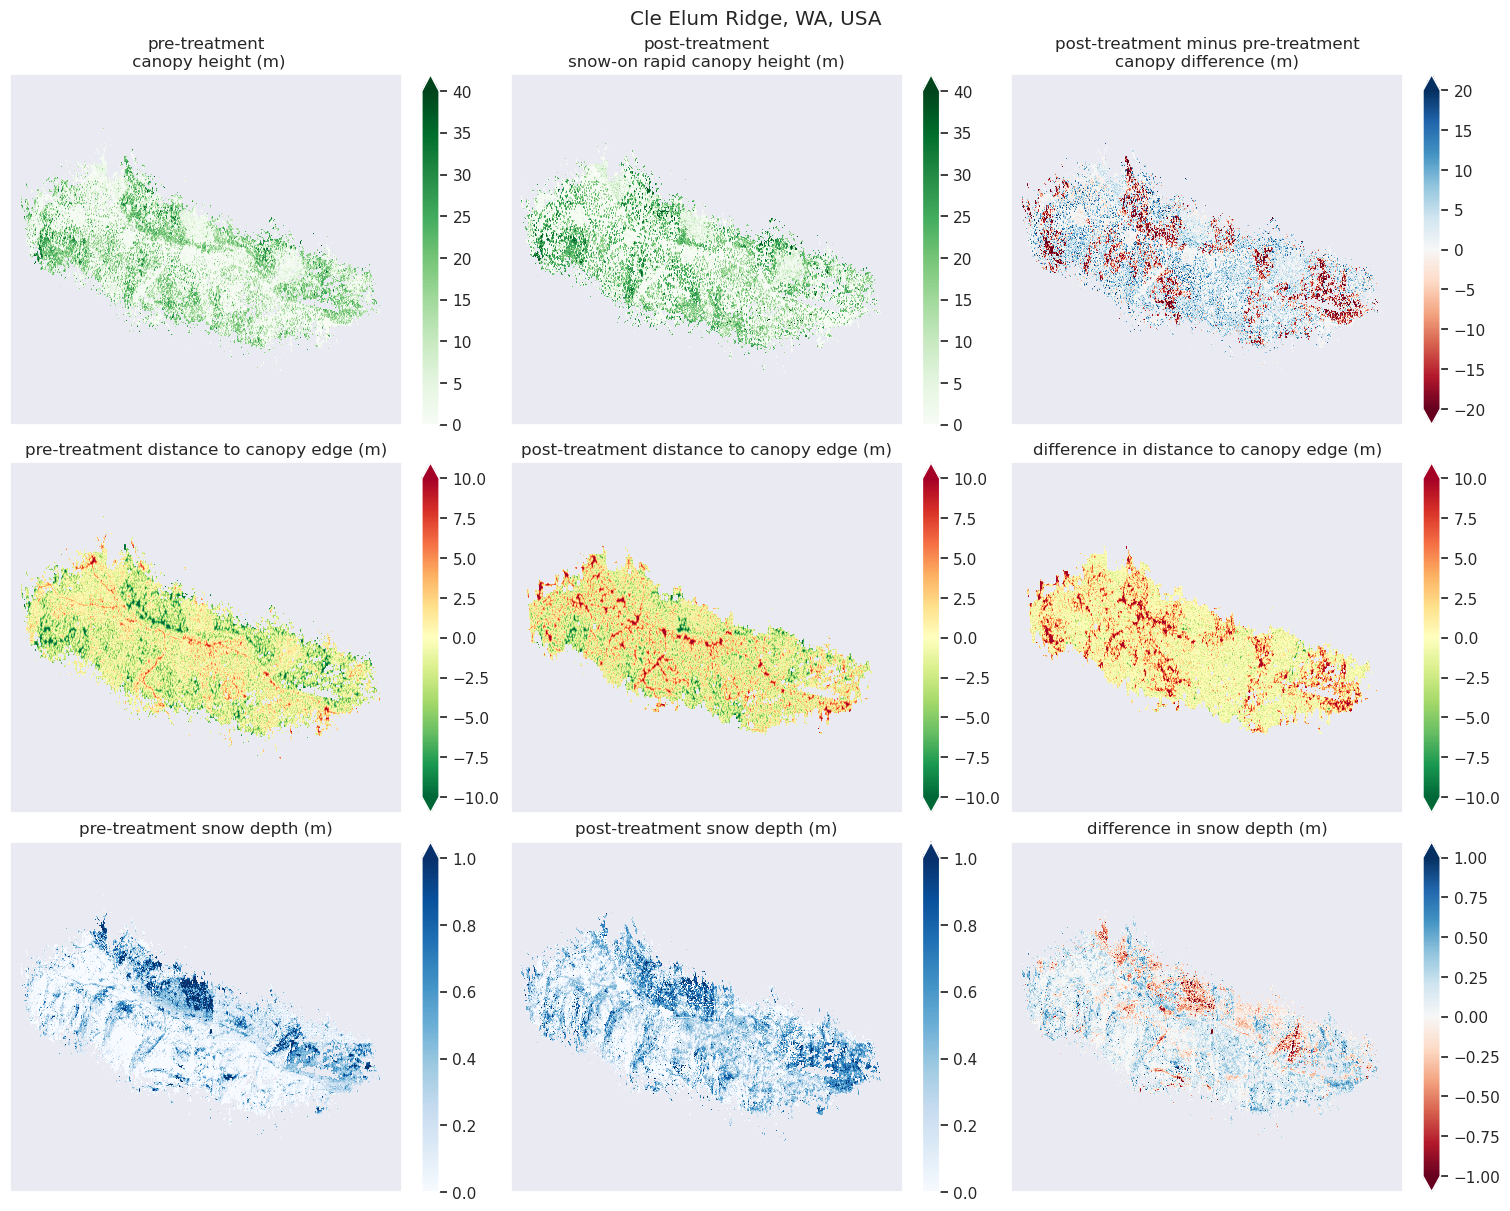

In [30]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,12), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('pre-treatment\n canopy height (m)')
axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment snow depth (m)')
axes[2,1].set_title('post-treatment snow depth (m)')
axes[2,2].set_title('difference in snow depth (m)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])
plt.show()

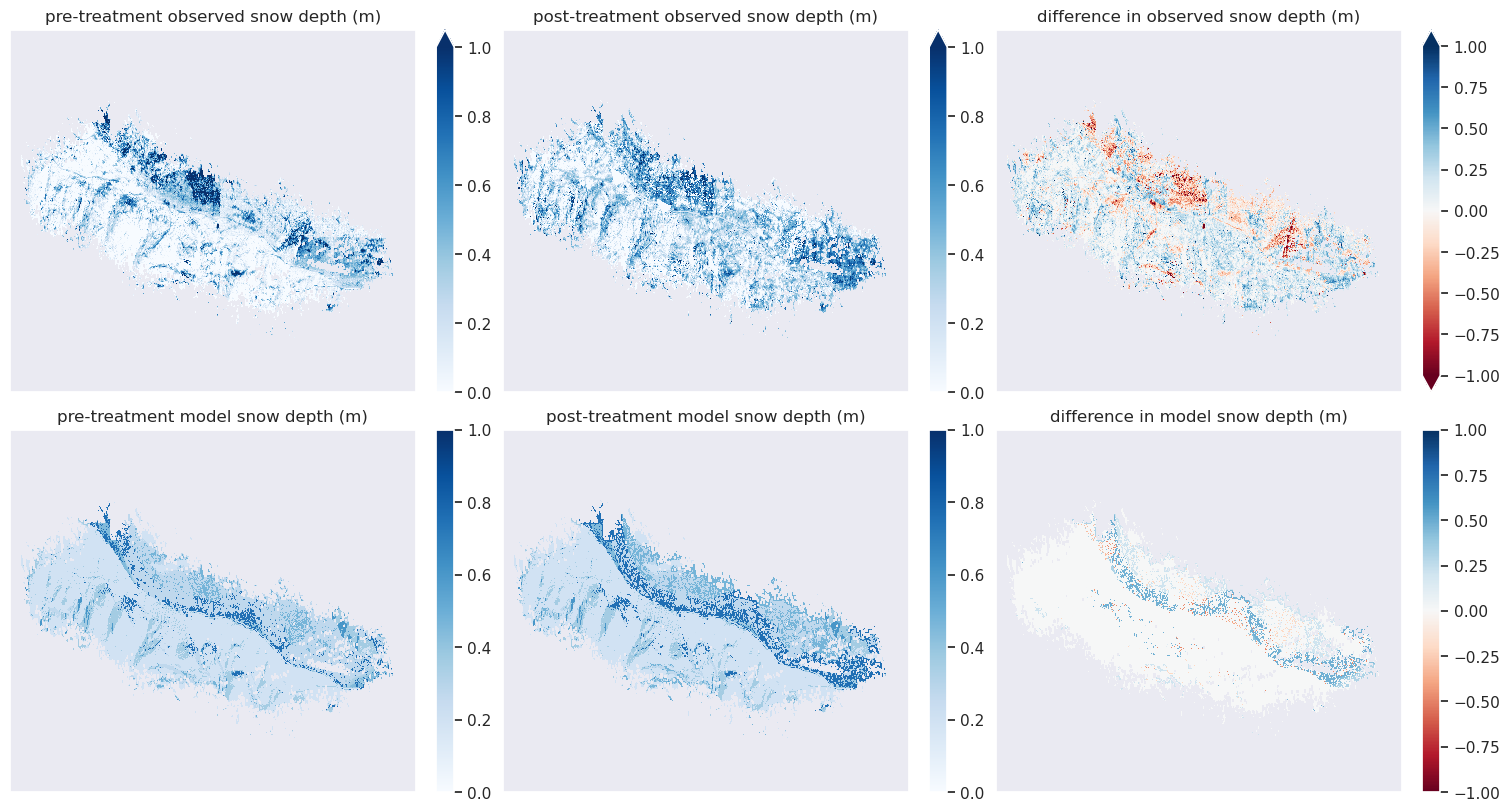

In [31]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,8), constrained_layout = True)

# row 3 
ds['diff_hs_rapid_ncalm'] = ds['hs_rapid'] - ds['hs_ncalm']
ds.hs_ncalm.plot(ax=axes[0,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[0,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[0,0].set_title('pre-treatment observed snow depth (m)')
axes[0,1].set_title('post-treatment observed snow depth (m)')
axes[0,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)
ds.hs_ncalm_model.plot(ax=axes[1,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid_model.plot(ax=axes[1,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm_model.plot(ax=axes[1,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment model snow depth (m)')
axes[1,1].set_title('post-treatment model snow depth (m)')
axes[1,2].set_title('difference in model snow depth (m)')

# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])
plt.show()

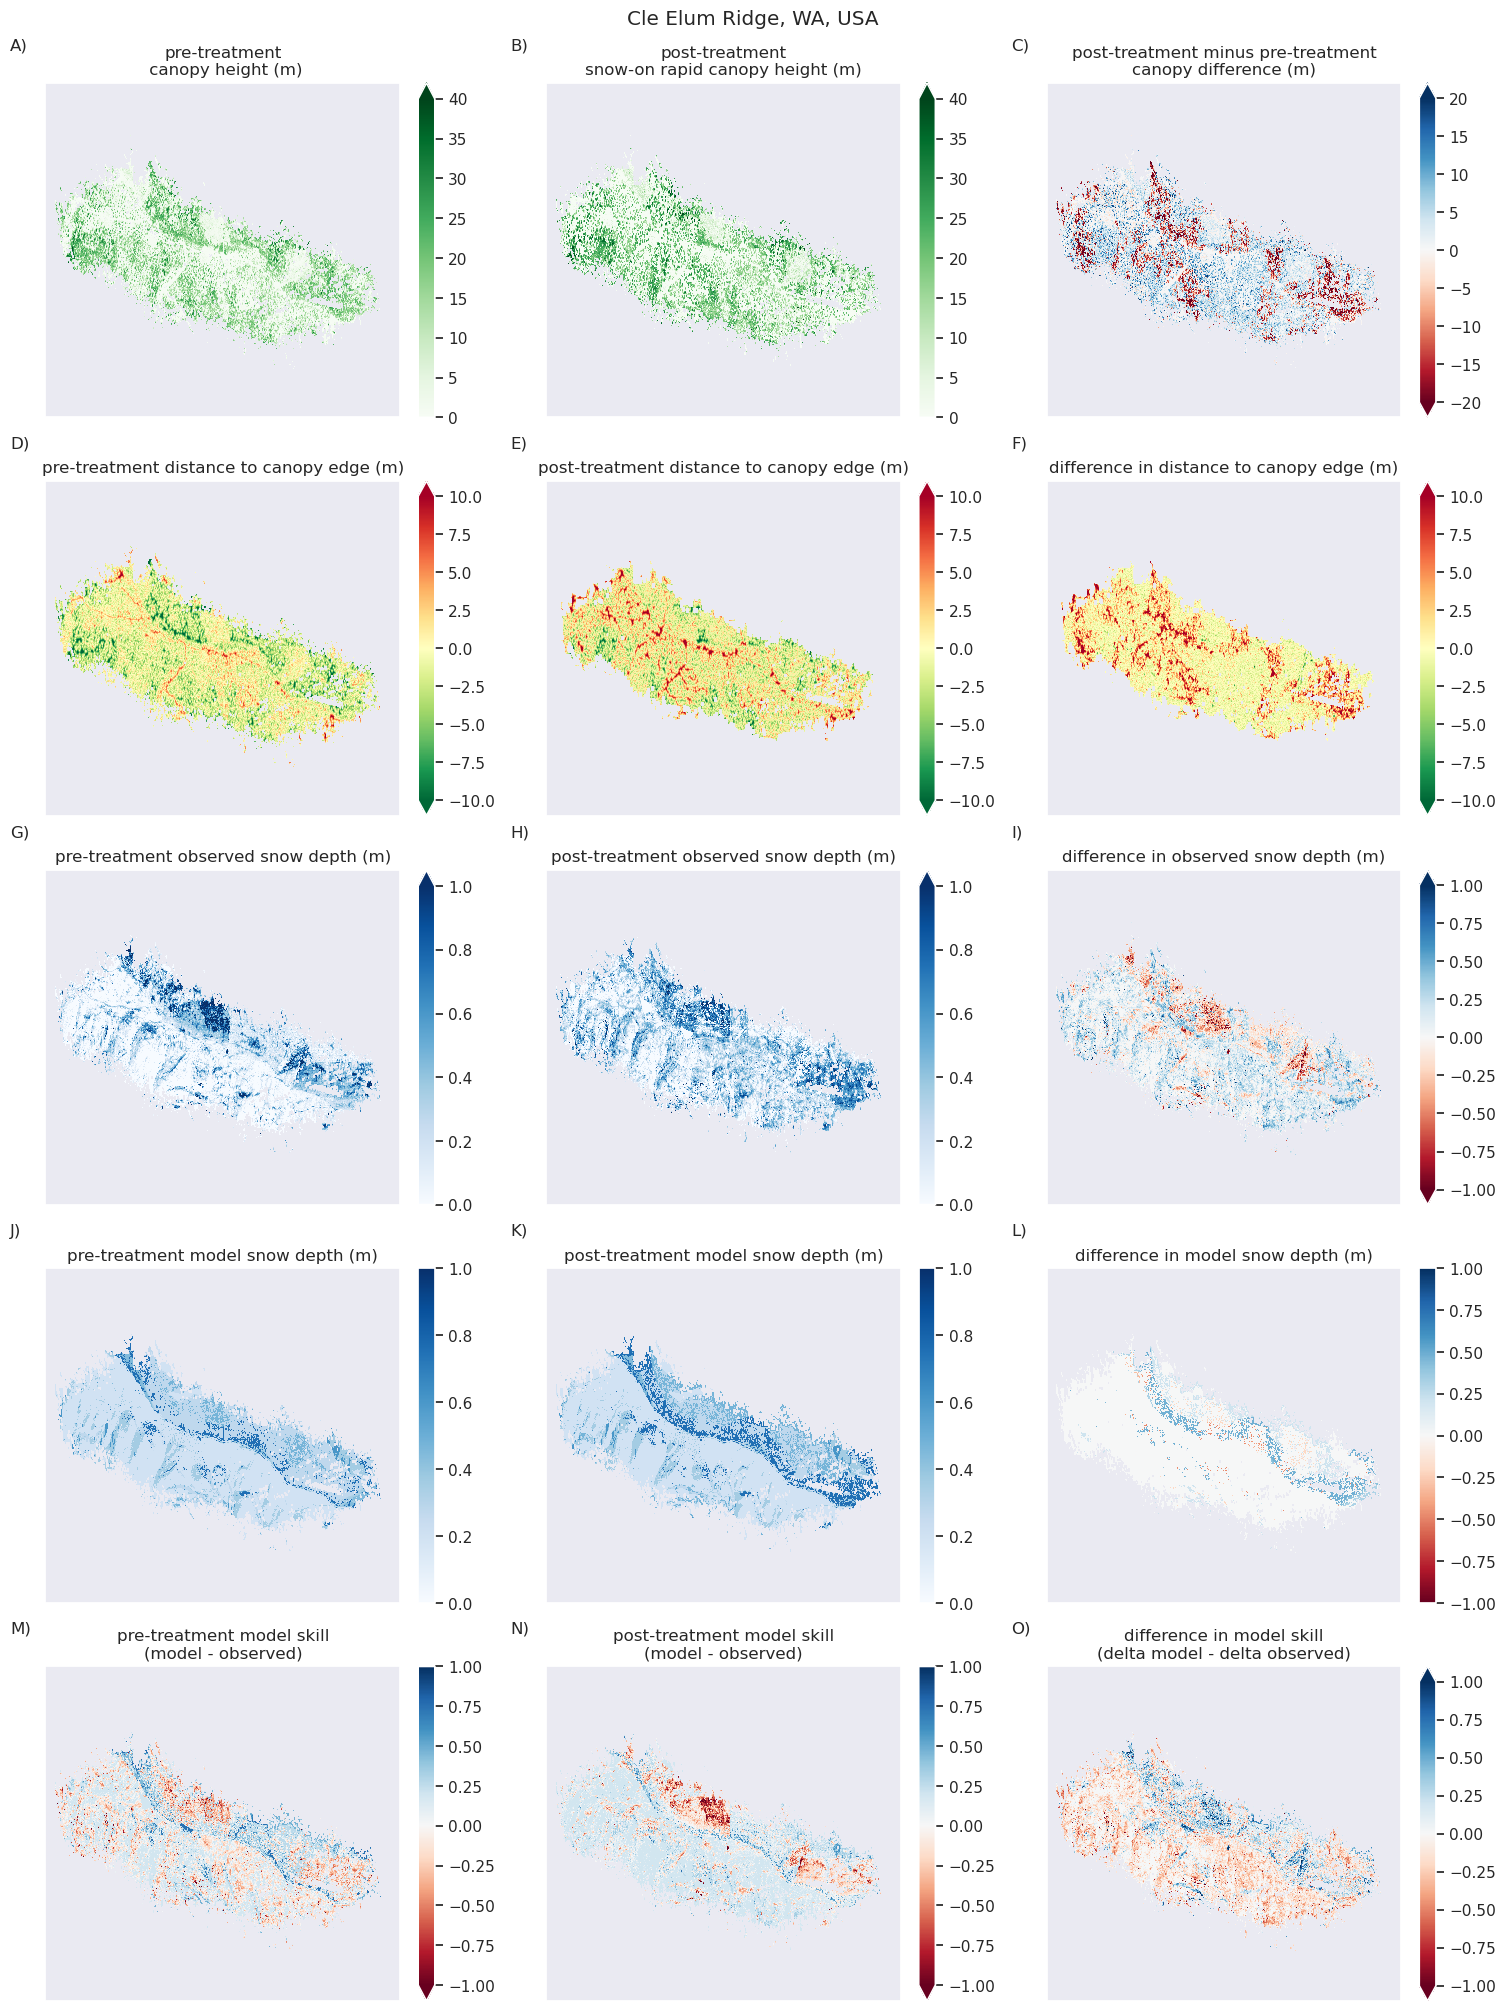

In [ ]:
fig, axes = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(15,20), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('pre-treatment\n canopy height (m)')
axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment observed snow depth (m)')
axes[2,1].set_title('post-treatment observed snow depth (m)')
axes[2,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)
ds.hs_ncalm_model.plot(ax=axes[3,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid_model.plot(ax=axes[3,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm_model.plot(ax=axes[3,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[3,0].set_title('pre-treatment model snow depth (m)')
axes[3,1].set_title('post-treatment model snow depth (m)')
axes[3,2].set_title('difference in model snow depth (m)')

# row 5 (random forest model skill)
ds.diff_hs_model_rapid.plot(ax=axes[4,0], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_model_ncalm.plot(ax=axes[4,1], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})
ds.diff_delta_hs_model_obs.plot(ax=axes[4,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

# modeled pre-treatment snow depth - observed pre-treatment snow depth
# modeled post-treatment snow depth - observed post-treatment snow depth
# modeled delta snow depth - observed delta snow depth

axes[4,0].set_title('pre-treatment model skill\n(model - observed)')
axes[4,1].set_title('post-treatment model skill\n(model - observed)')
axes[4,2].set_title('difference in model skill\n(delta model - delta observed)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])

# row 4 
axes[3,0].set_xlabel(''); axes[3,0].set_ylabel(''); axes[3,0].set_xticks([]); axes[3,0].set_yticks([])
axes[3,1].set_xlabel(''); axes[3,1].set_ylabel(''); axes[3,1].set_xticks([]); axes[3,1].set_yticks([])
axes[3,2].set_xlabel(''); axes[3,2].set_ylabel(''); axes[3,2].set_xticks([]); axes[3,2].set_yticks([])

# row 5 
axes[4,0].set_xlabel(''); axes[4,0].set_ylabel(''); axes[4,0].set_xticks([]); axes[4,0].set_yticks([])
axes[4,1].set_xlabel(''); axes[4,1].set_ylabel(''); axes[4,1].set_xticks([]); axes[4,1].set_yticks([])
axes[4,2].set_xlabel(''); axes[4,2].set_ylabel(''); axes[4,2].set_xticks([]); axes[4,2].set_yticks([])

# add A) B) C) etc labels to the upper left side of each subplot
# row 1
axes[0,0].text(0.0, 0.9, 'A)', transform=axes[0,0].transAxes, size=12)
axes[0,1].text(0.0, 0.9, 'B)', transform=axes[0,1].transAxes, size=12)
axes[0,2].text(0.0, 0.9, 'C)', transform=axes[0,2].transAxes, size=12)

# row 2
axes[1,0].text(0.0, 0.9, 'D)', transform=axes[1,0].transAxes, size=12)
axes[1,1].text(0.0, 0.9, 'E)', transform=axes[1,1].transAxes, size=12)
axes[1,2].text(0.0, 0.9, 'F)', transform=axes[1,2].transAxes, size=12)

# row 3
axes[2,0].text(0.0, 0.9, 'G)', transform=axes[2,0].transAxes, size=12)
axes[2,1].text(0.0, 0.9, 'H)', transform=axes[2,1].transAxes, size=12)
axes[2,2].text(0.0, 0.9, 'I)', transform=axes[2,2].transAxes, size=12)

# row 4
axes[3,0].text(0.0, 0.9, 'J)', transform=axes[3,0].transAxes, size=12)
axes[3,1].text(0.0, 0.9, 'K)', transform=axes[3,1].transAxes, size=12)
axes[3,2].text(0.0, 0.9, 'L)', transform=axes[3,2].transAxes, size=12)

# row 5
axes[4,0].text(0.0, 0.9, 'M)', transform=axes[4,0].transAxes, size=12)
axes[4,1].text(0.0, 0.9, 'N)', transform=axes[4,1].transAxes, size=12)
axes[4,2].text(0.0, 0.9, 'O)', transform=axes[4,2].transAxes, size=12)

plt.show()

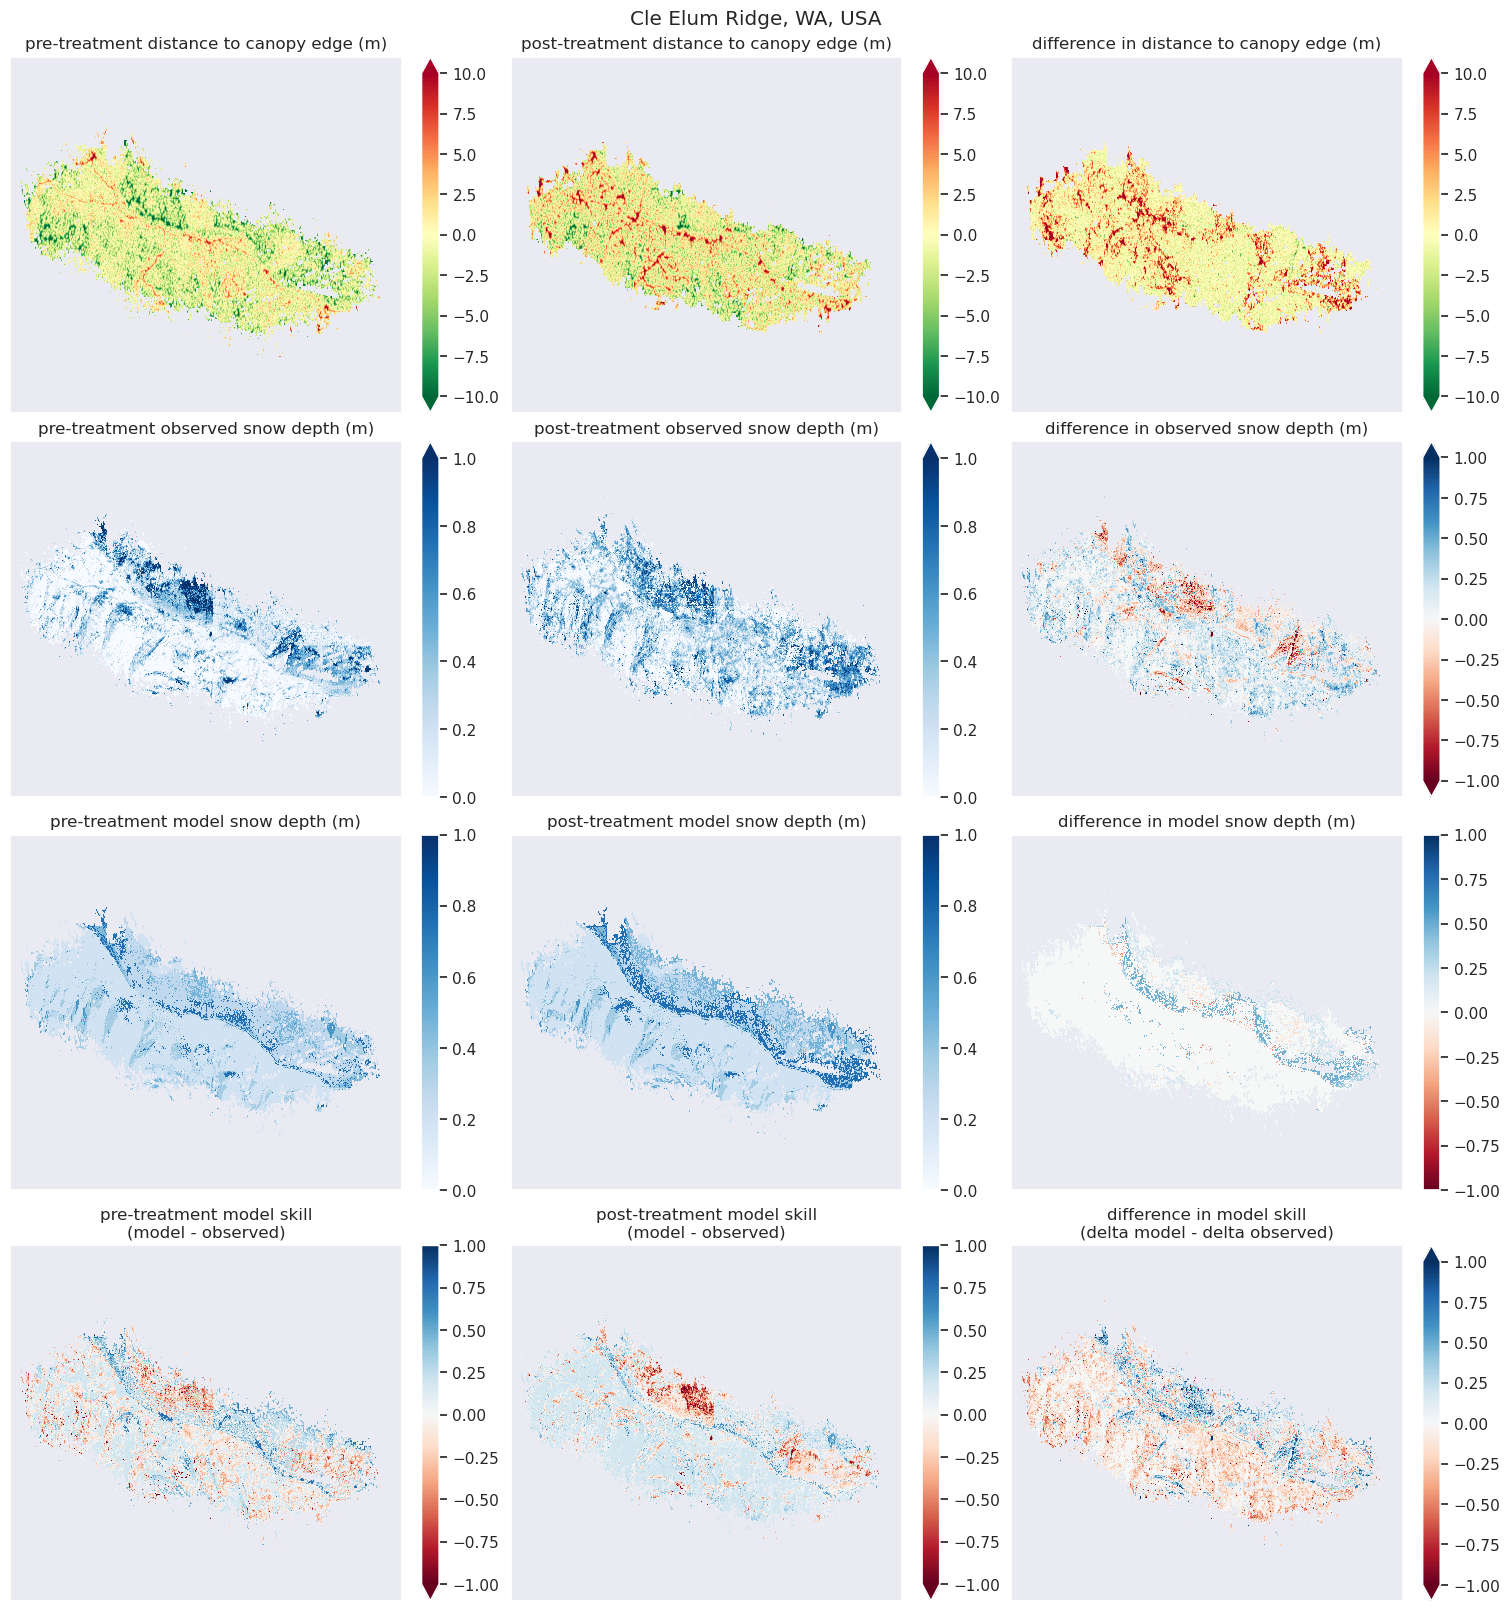

In [33]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(15,16), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

# # row 1
# # ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# # ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

# axes[0,0].set_title('pre-treatment\n canopy height (m)')
# axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
# axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[0,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[0,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[0,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[0,0].set_title('pre-treatment distance to canopy edge (m)')
axes[0,1].set_title('post-treatment distance to canopy edge (m)')
axes[0,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[1,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[1,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[1,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment observed snow depth (m)')
axes[1,1].set_title('post-treatment observed snow depth (m)')
axes[1,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)
ds.hs_ncalm_model.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid_model.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm_model.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment model snow depth (m)')
axes[2,1].set_title('post-treatment model snow depth (m)')
axes[2,2].set_title('difference in model snow depth (m)')

# row 5 (random forest model skill)
ds.diff_hs_model_rapid.plot(ax=axes[3,0], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_model_ncalm.plot(ax=axes[3,1], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})
ds.diff_delta_hs_model_obs.plot(ax=axes[3,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

# modeled pre-treatment snow depth - observed pre-treatment snow depth
# modeled post-treatment snow depth - observed post-treatment snow depth
# modeled delta snow depth - observed delta snow depth

axes[3,0].set_title('pre-treatment model skill\n(model - observed)')
axes[3,1].set_title('post-treatment model skill\n(model - observed)')
axes[3,2].set_title('difference in model skill\n(delta model - delta observed)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])

# row 4 
axes[3,0].set_xlabel(''); axes[3,0].set_ylabel(''); axes[3,0].set_xticks([]); axes[3,0].set_yticks([])
axes[3,1].set_xlabel(''); axes[3,1].set_ylabel(''); axes[3,1].set_xticks([]); axes[3,1].set_yticks([])
axes[3,2].set_xlabel(''); axes[3,2].set_ylabel(''); axes[3,2].set_xticks([]); axes[3,2].set_yticks([])

# # row 5 
# axes[4,0].set_xlabel(''); axes[4,0].set_ylabel(''); axes[4,0].set_xticks([]); axes[4,0].set_yticks([])
# axes[4,1].set_xlabel(''); axes[4,1].set_ylabel(''); axes[4,1].set_xticks([]); axes[4,1].set_yticks([])
# axes[4,2].set_xlabel(''); axes[4,2].set_ylabel(''); axes[4,2].set_xticks([]); axes[4,2].set_yticks([])
plt.show()

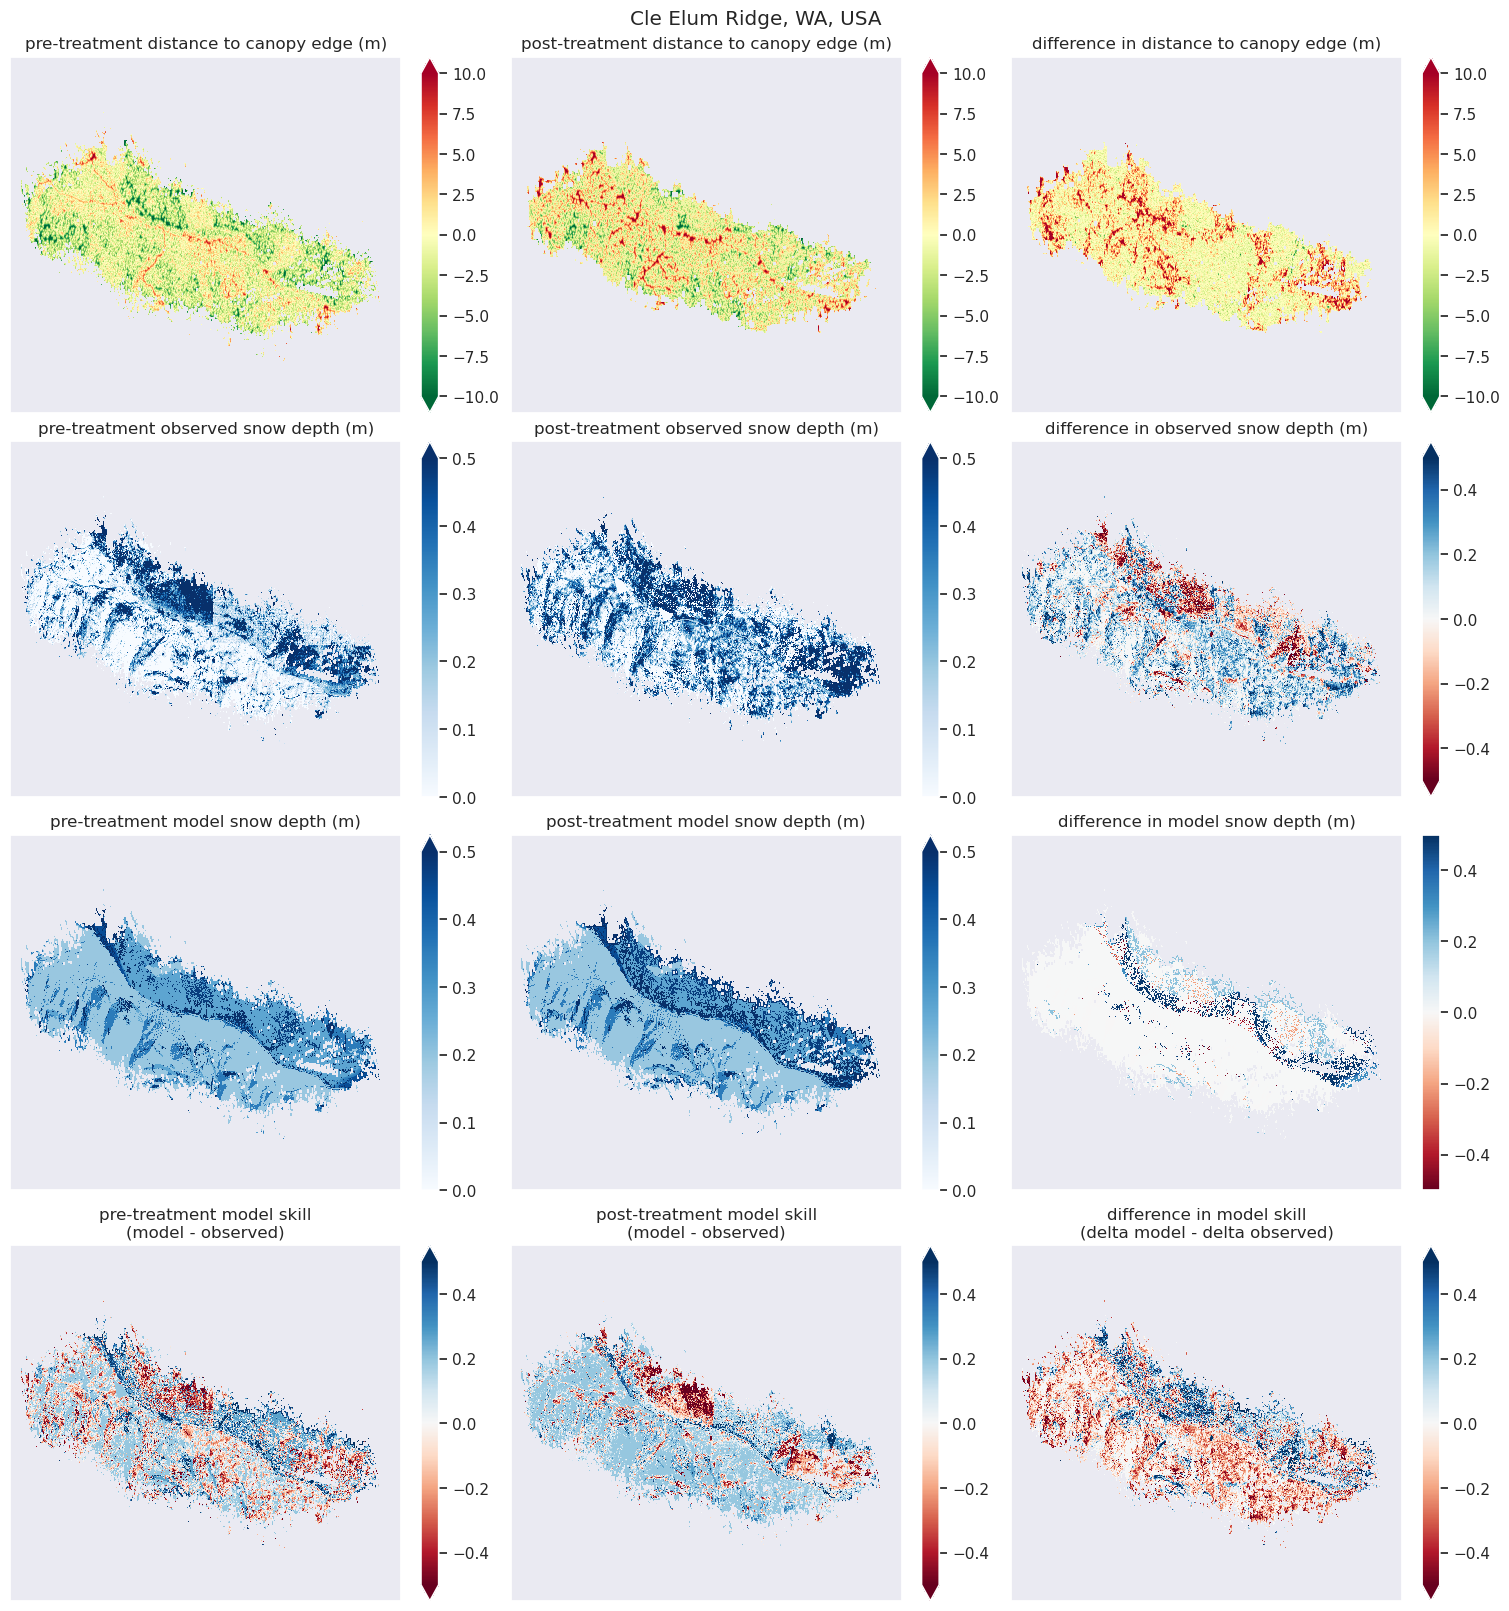

In [13]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(15,16), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

# # row 1
# # ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# # ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

# axes[0,0].set_title('pre-treatment\n canopy height (m)')
# axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
# axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[0,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[0,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[0,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[0,0].set_title('pre-treatment distance to canopy edge (m)')
axes[0,1].set_title('post-treatment distance to canopy edge (m)')
axes[0,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[1,0], cmap='Blues', vmin=0, vmax=.5, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[1,1], cmap='Blues', vmin=0, vmax=.5, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[1,2], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment observed snow depth (m)')
axes[1,1].set_title('post-treatment observed snow depth (m)')
axes[1,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)
ds.hs_ncalm_model.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=.5, cbar_kwargs={'label':''})
ds.hs_rapid_model.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=.5, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm_model.plot(ax=axes[2,2], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment model snow depth (m)')
axes[2,1].set_title('post-treatment model snow depth (m)')
axes[2,2].set_title('difference in model snow depth (m)')

# row 5 (random forest model skill)
ds.diff_hs_model_rapid.plot(ax=axes[3,0], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})
ds.diff_hs_model_ncalm.plot(ax=axes[3,1], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})
ds.diff_delta_hs_model_obs.plot(ax=axes[3,2], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})

# modeled pre-treatment snow depth - observed pre-treatment snow depth
# modeled post-treatment snow depth - observed post-treatment snow depth
# modeled delta snow depth - observed delta snow depth

axes[3,0].set_title('pre-treatment model skill\n(model - observed)')
axes[3,1].set_title('post-treatment model skill\n(model - observed)')
axes[3,2].set_title('difference in model skill\n(delta model - delta observed)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])

# row 4 
axes[3,0].set_xlabel(''); axes[3,0].set_ylabel(''); axes[3,0].set_xticks([]); axes[3,0].set_yticks([])
axes[3,1].set_xlabel(''); axes[3,1].set_ylabel(''); axes[3,1].set_xticks([]); axes[3,1].set_yticks([])
axes[3,2].set_xlabel(''); axes[3,2].set_ylabel(''); axes[3,2].set_xticks([]); axes[3,2].set_yticks([])

# # row 5 
# axes[4,0].set_xlabel(''); axes[4,0].set_ylabel(''); axes[4,0].set_xticks([]); axes[4,0].set_yticks([])
# axes[4,1].set_xlabel(''); axes[4,1].set_ylabel(''); axes[4,1].set_xticks([]); axes[4,1].set_yticks([])
# axes[4,2].set_xlabel(''); axes[4,2].set_ylabel(''); axes[4,2].set_xticks([]); axes[4,2].set_yticks([])
plt.show()

Just plot distance to canopy edge, and model to see them next to eachother

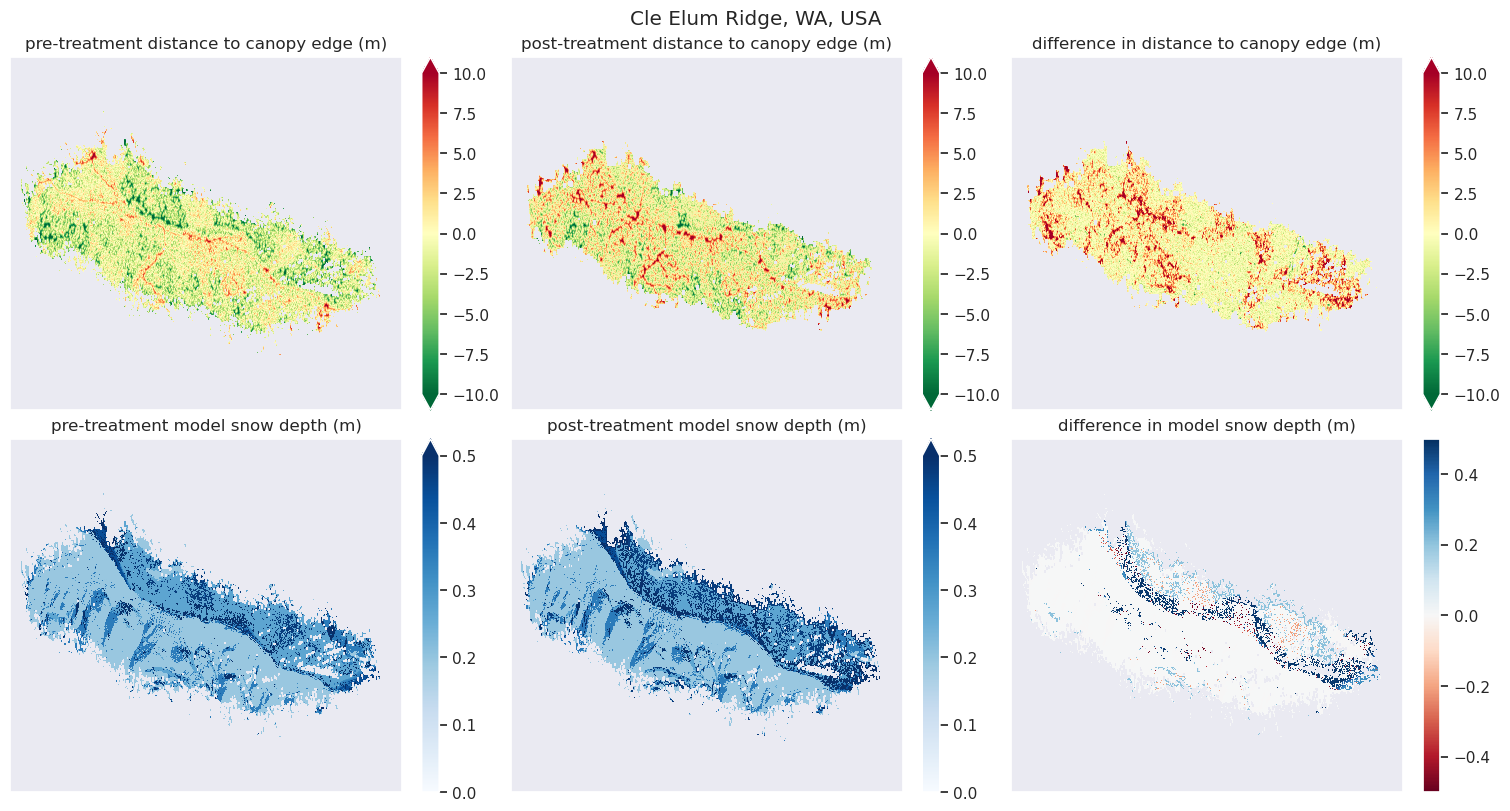

In [36]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,8), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')

# # row 1
# # ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# # ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

# axes[0,0].set_title('pre-treatment\n canopy height (m)')
# axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
# axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[0,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[0,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[0,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[0,0].set_title('pre-treatment distance to canopy edge (m)')
axes[0,1].set_title('post-treatment distance to canopy edge (m)')
axes[0,2].set_title('difference in distance to canopy edge (m)')

# # row 3 
# ds.hs_ncalm.plot(ax=axes[1,0], cmap='Blues', vmin=0, vmax=.5, cbar_kwargs={'label':''})
# ds.hs_rapid.plot(ax=axes[1,1], cmap='Blues', vmin=0, vmax=.5, cbar_kwargs={'label':''})
# ds.diff_hs_rapid_ncalm.plot(ax=axes[1,2], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})

# axes[1,0].set_title('pre-treatment observed snow depth (m)')
# axes[1,1].set_title('post-treatment observed snow depth (m)')
# axes[1,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)
ds.hs_ncalm_model.plot(ax=axes[1,0], cmap='Blues', vmin=0, vmax=.5, cbar_kwargs={'label':''})
ds.hs_rapid_model.plot(ax=axes[1,1], cmap='Blues', vmin=0, vmax=.5, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm_model.plot(ax=axes[1,2], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment model snow depth (m)')
axes[1,1].set_title('post-treatment model snow depth (m)')
axes[1,2].set_title('difference in model snow depth (m)')

# # row 5 (random forest model skill)
# ds.diff_hs_model_rapid.plot(ax=axes[3,0], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})
# ds.diff_hs_model_ncalm.plot(ax=axes[3,1], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})
# ds.diff_delta_hs_model_obs.plot(ax=axes[3,2], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})

# axes[3,0].set_title('pre-treatment model skill\n(model - observed)')
# axes[3,1].set_title('post-treatment model skill\n(model - observed)')
# axes[3,2].set_title('difference in model skill\n(delta model - delta observed)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# # row 3 
# axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
# axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
# axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])

# # row 4 
# axes[3,0].set_xlabel(''); axes[3,0].set_ylabel(''); axes[3,0].set_xticks([]); axes[3,0].set_yticks([])
# axes[3,1].set_xlabel(''); axes[3,1].set_ylabel(''); axes[3,1].set_xticks([]); axes[3,1].set_yticks([])
# axes[3,2].set_xlabel(''); axes[3,2].set_ylabel(''); axes[3,2].set_xticks([]); axes[3,2].set_yticks([])

# # row 5 
# axes[4,0].set_xlabel(''); axes[4,0].set_ylabel(''); axes[4,0].set_xticks([]); axes[4,0].set_yticks([])
# axes[4,1].set_xlabel(''); axes[4,1].set_ylabel(''); axes[4,1].set_xticks([]); axes[4,1].set_yticks([])
# axes[4,2].set_xlabel(''); axes[4,2].set_ylabel(''); axes[4,2].set_xticks([]); axes[4,2].set_yticks([])
plt.show()

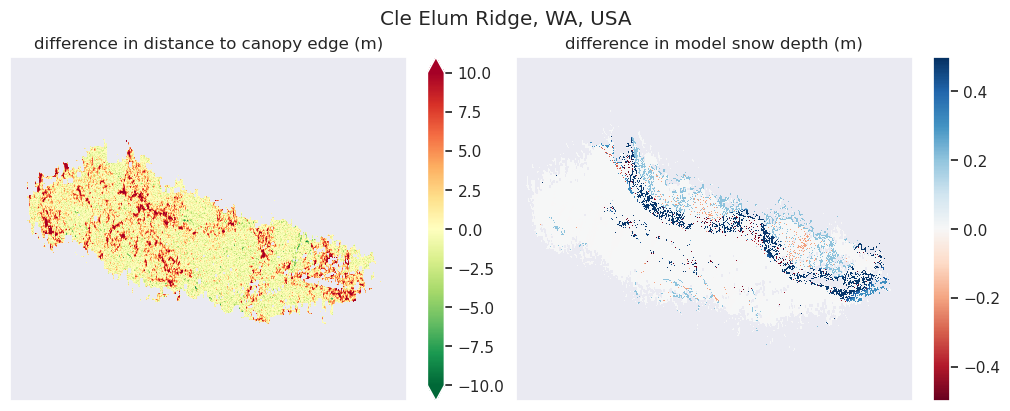

In [14]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA')
ds.diff_dce_rapid_ncalm.plot(ax=axes[0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm_model.plot(ax=axes[1], cmap='RdBu', vmin=-.5, vmax=.5, cbar_kwargs={'label':''})

axes[0].set_title('difference in distance to canopy edge (m)')
axes[1].set_title('difference in model snow depth (m)')

axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])
axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

plt.show()